The following project aims to train a Computer Vision model which can not only correctly predict about the presence of a cat or a dog in an image but should also draw a bounding box around its face. It's an approach which doesn't use any object detection algorithm like YOLO, Faster RCNN or Single Shot Detector(SSD) out-of-the-box but tries to use the same neural network for both the tasks of classification and localization.<br>
One can download the dataset [here](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from collections import namedtuple
import csv
from PIL import Image, ImageOps
# importing XML parsing library for parsing the data
import xml.etree.ElementTree as ET
# BoundingBox
Bounding_Box = namedtuple('Bounding_Box', 'xmin ymin xmax ymax')
TARGET_SIZE = (224, 224)

The following function to read the xml and return the values for xmin, ymin, xmax, ymax for forming the bounding box

In [5]:
def new_bounding_box(xml_annot_path):
    tree = ET.parse(xml_annot_path)
    root = tree.getroot()
    path_to_box = './object/bndbox/'
    xmin = int(root.find(path_to_box + "xmin").text)
    ymin = int(root.find(path_to_box + "ymin").text)
    xmax = int(root.find(path_to_box + "xmax").text)
    ymax = int(root.find(path_to_box + "ymax").text)
    return Bounding_Box(xmin, ymin, xmax, ymax)

The below code aimes to make every image, square (if it is already not) by performing padding on each image and then accordingly we are adjusting the size of the bounding box too in that image.

In [6]:
def resize_image_and_boundbox(path_to_image, bounding_box=None, target_size=None):
    image = Image.open(path_to_image)
    width, height = image.size
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0


    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2

    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))

    # When we pad the image to a square, we need to adjust all the bounding box values by the amounts we added on the left or top.
    if bounding_box is not None:
        new_xmin = bounding_box.xmin + w_pad
        new_xmax = bounding_box.xmax + w_pad
        new_ymin = bounding_box.ymin + h_pad
        new_ymax = bounding_box.ymax + h_pad

        # scaling the image as per provided target size
        if target_size is not None:
            width, height = image.size
            image = image.resize(target_size)
            width_scale = target_size[0] / width
            height_scale = target_size[1] / height

            #scaling the bounding box as per new target size
            if bounding_box is not None:
                new_xmin = new_xmin * width_scale
                new_xmax = new_xmax * width_scale
                new_ymin = new_ymin * height_scale
                new_ymax = new_ymax * height_scale

    image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)

    # The image data is a 3D array such that 3 channels, RGB of target_size. (RGB values are 0-255)
    if bounding_box is None:
        return image_data, None
    return image_data, Bounding_Box(new_xmin, new_ymin, new_xmax, new_ymax)


In [7]:
img_data = '/content/drive/MyDrive/Oxford_data/images'
img_classes = '/content/drive/MyDrive/Oxford_data/annotations/list.txt'
xml_annot = '/content/drive/MyDrive/Oxford_data/annotations/xmls'

In [8]:
def load_and_resize_img(name_img):
    path_to_image = os.path.join(img_data, name_img + '.jpg')
    path_to_xml = os.path.join(xml_annot, name_img + '.xml')
    original_bounding_box = new_bounding_box(path_to_xml)
    image_data, bounding_box = resize_image_and_boundbox(path_to_image, original_bounding_box, TARGET_SIZE)
    return image_data, bounding_box


The below code displays the image with bounding box around it.

In [9]:
def display_img_and_box(image_data, bounding_box, real_box=None):
    fig, ax = plt.subplots(1)
    ax.imshow(image_data)

    box_1 = patches.Rectangle((bounding_box.xmin, bounding_box.ymin),
                             bounding_box.xmax - bounding_box.xmin,
                             bounding_box.ymax - bounding_box.ymin,
                             linewidth=3, edgecolor='y', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(box_1)

    # Creating another Rectangular patch for the real one
    if real_box is not None:
        box_2 = patches.Rectangle((real_box.xmin, real_box.ymin),
                                 real_box.xmax - real_box.xmin,
                                 real_box.ymax - real_box.ymin,
                                 linewidth=2, edgecolor='b', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(box_2)

        # FOR FINDING INTERSECTION OVER UNION
        xA = max(bounding_box.xmin, real_box.xmin)
        yA = max(bounding_box.ymin, real_box.ymin)
        xB = min(bounding_box.xmax, real_box.xmax)
        yB = min(bounding_box.ymax, real_box.ymax)

        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        box_1_Area = (bounding_box.xmax - bounding_box.xmin + 1) * (bounding_box.ymax - bounding_box.ymin + 1)
        box_2_Area = (real_box.xmax - real_box.xmin + 1) * (real_box.ymax - real_box.ymin + 1)

        iou = interArea / float(box_1_Area + box_2_Area - interArea)

        # By intersection of union, I mean intersection over union (IOU) itself
        print('Intersection of Union =', iou)

    plt.show()


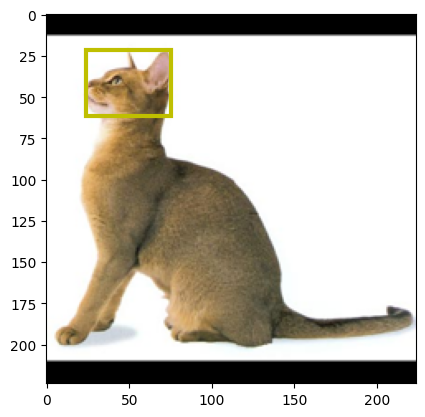

In [17]:
name_img = 'Abyssinian_19'
image, bounding_box = load_and_resize_img(name_img)
display_img_and_box(image, bounding_box)


**Preprocssing our desired length of dataset:<br>**
Following script reads the CSV file using the csv module.<br>

Then, for each image in the CSV file, it attempts to load and resize the image using the load_and_resize_img function. Images that lack bounding box annotations are handled gracefully through a FileNotFoundError exception, with corresponding messages printed.<br>

The script then forms a dataset (processed_data) containing tuples of processed image data, species labels (cat = 0, dog = 1), and bounding boxes. Now, these images along with their bounding boxes are going to be fed into the neural network.<br>

Also, progress is printed for each processed sample. Additionally, the script stops processing after 3000 samples, considering RAM issues.

In [12]:
processed_data = []

with open(img_classes) as csv_list_file:
    csv_reader = csv.reader(csv_list_file, delimiter=' ')
    for row in csv_reader:
        if row[0].startswith('#'):
            continue

        name_img, class_id, species, breed_id = row

        # Following block of code for loading and resizing images and handling those images which don't have a Bounding box
        try:
            image, bounding_box = load_and_resize_img(name_img)
        except FileNotFoundError:
            # This actually happens quite a lot, as you can see in the output.
            # we end up with 7349 samples.
            print(f'Cannot find annotations for {name_img}: so skipped it')
            continue

        # cat = 0 and dog = 1.
        data_tuple = (image, int(species) - 1, bounding_box)
        processed_data.append(data_tuple)

        print(f'Processed {len(processed_data)} samples')

        if len(processed_data) == 3000:
            break

processed_data = np.array(processed_data)


Processed 1 samples
Processed 2 samples
Processed 3 samples
Processed 4 samples
Cannot find annotations for Abyssinian_104: so skipped it
Processed 5 samples
Processed 6 samples
Processed 7 samples
Processed 8 samples
Processed 9 samples
Processed 10 samples
Processed 11 samples
Processed 12 samples
Processed 13 samples
Processed 14 samples
Processed 15 samples
Processed 16 samples
Processed 17 samples
Processed 18 samples
Processed 19 samples
Processed 20 samples
Processed 21 samples
Processed 22 samples
Processed 23 samples
Processed 24 samples
Processed 25 samples
Processed 26 samples
Processed 27 samples
Processed 28 samples
Processed 29 samples
Processed 30 samples
Processed 31 samples
Processed 32 samples
Processed 33 samples
Processed 34 samples
Processed 35 samples
Processed 36 samples
Processed 37 samples
Processed 38 samples
Processed 39 samples
Processed 40 samples
Processed 41 samples
Processed 42 samples
Processed 43 samples
Processed 44 samples
Processed 45 samples
Proces

<ipython-input-12-f30d7848783f>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  processed_data = np.array(processed_data)


1629 Cat image


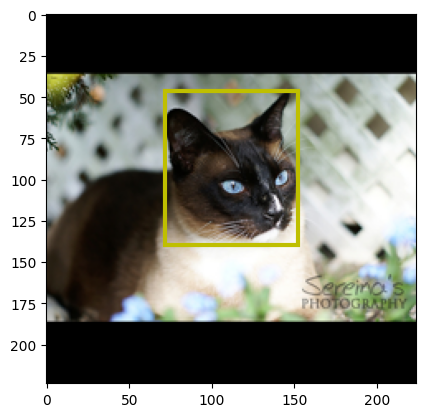

2769 Dog image


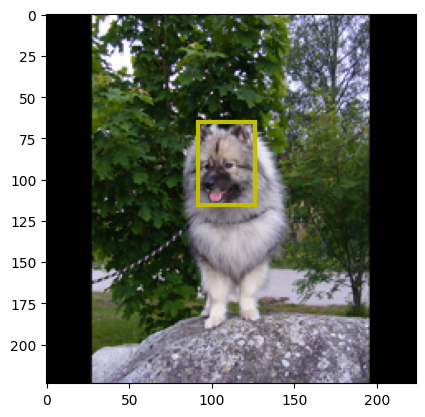

2030 Dog image


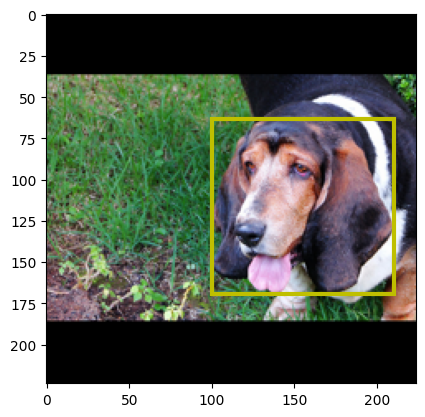

307 Cat image


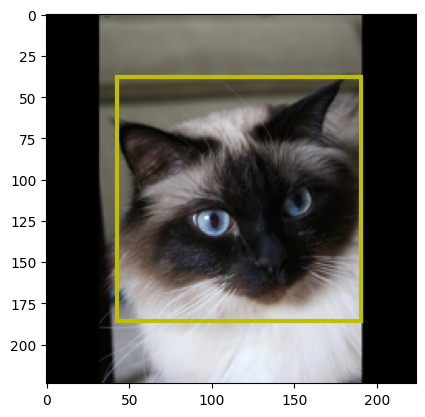

2297 Cat image


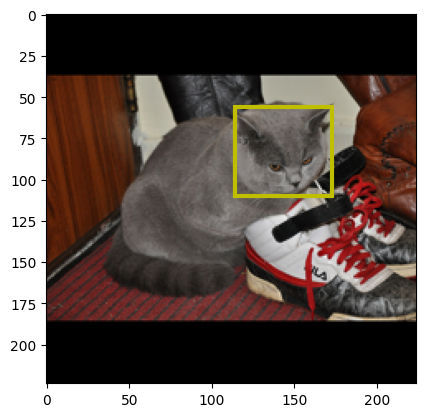

1859 Cat image


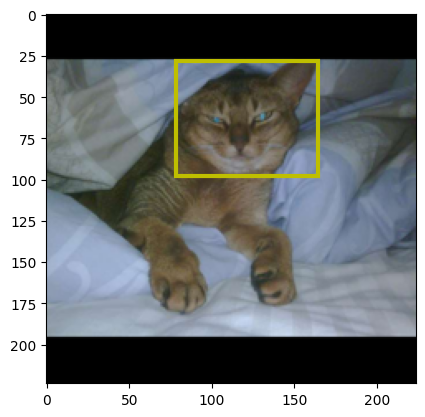

2816 Dog image


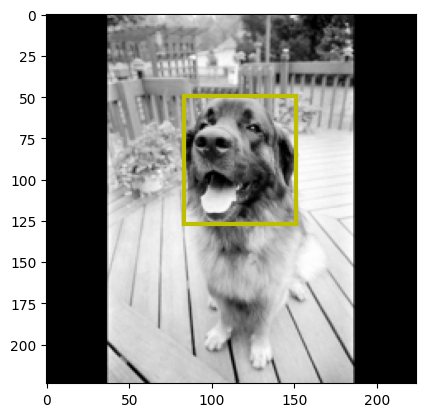

In [19]:
 #For checking our dataset that how it looks, let's print few of them
k = 0
while k < 7:
    i = np.random.randint(len(processed_data))
    image, species, bounding_box = processed_data[i]

    if species == 0:
        print(i, "Cat image")
    elif species == 1:
        print(i, "Dog image")
    else:
        print("ERROR FOUND: This is of invalid species type")

    display_img_and_box(image, bounding_box)
    k = k +1

Creating train and validation data in proper formats

In [13]:
validation_split = 0.2
x_train = []
y_train_class = []
y_train_box = []
x_validation = []
y_validation_class = []
y_validation_box = []

for image, species, bounding_box in processed_data:
    if np.random.random() > validation_split:
        x_train.append(preprocess_input(image))
        y_train_class.append(species)
        y_train_box.append(bounding_box)
    else:
        x_validation.append(preprocess_input(image))
        y_validation_class.append(species)
        y_validation_box.append(bounding_box)

x_train = np.array(x_train)
y_train_class = np.array(y_train_class)
y_train_box = np.array(y_train_box)
x_validation = np.array(x_validation)
y_validation_class = np.array(y_validation_class)
y_validation_box = np.array(y_validation_box)


**Transfer Learning on ResNet50:** <br>
Among all the combined layers of ResNet50 we are only taking first 75 trained layers with thier optimal weights for feature extraction. We pruned remaining layer for faster iteration here and also to add our own custom layers for classification and localisation tasks.<br>
For **classification** of an image into cat or dog category, first custom layer that we add is GlobalAveragePoling2D. It reduces the spatial dimensions of the data and computes the average value for each feature, resulting in a fixed-size output regardless of the input size. Then, a Dense layer with a single unit and a sigmoid activation function is added to the classification_output. This layer is commonly used for binary classification problems, and the sigmoid activation produces a probability output.<br>
For **localisation** task, we first add a Flatten layer to the output of the pruned MobileNet model. This flattens the spatial dimensions of the output. Then, a Dense layer with 4 units and ReLU activation is added to the flattened output. This suggests that the model is designed for a task involving bounding box regression with four output values (xmin, ymin, xmax, ymax).<br>
Finally, a new model (model) is created using the Keras Functional API. It takes the input from pruned mobilenet and has two outputs: classification_output and localization_output. This suggests a multi-task model where the network is simultaneously trained for classification and bounding box regression.

In [21]:
# Load ResNet50 with ImageNet weights
base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# Select the layers up to the 90th layer and create a new model with the selected layers
pre_trained_resnet1 = Model(inputs=[base_model1.input], outputs=[base_model1.layers[75].output])

# Classification output
classification_output1 = GlobalAveragePooling2D()(pre_trained_resnet1.output)
classification_output1 = Dense(units=1, activation='sigmoid')(classification_output1)

# localization output
localization_output1 = Flatten()(pre_trained_resnet1.output)
localization_output1 = Dense(units=4, activation='relu')(localization_output1)

# Combine into the final model
model1 = Model(inputs=[pre_trained_resnet1.input], outputs=[classification_output1, localization_output1])

# Display the summary
model1.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                       

In [22]:
from tensorflow.keras.optimizers import Adam
model1.compile(optimizer='adam', metrics=['accuracy'],loss=['binary_crossentropy', 'mse'],loss_weights=[800, 1]  )

history1 = model1.fit(x_train, [y_train_class, y_train_box], validation_data=(x_validation, [y_validation_class, y_validation_box]),epochs=10,verbose=True)

history1

Epoch 1/10
76/76 [==============================] - 42s 245ms/step - loss: 1116.3809 - dense_loss: 0.3965 - dense_1_loss: 799.1514 - dense_accuracy: 0.8172 - dense_1_accuracy: 0.8019 - val_loss: 1638.9337 - val_dense_loss: 0.4668 - val_dense_1_loss: 1265.4587 - val_dense_accuracy: 0.8484 - val_dense_1_accuracy: 0.6917
Epoch 2/10
76/76 [==============================] - 14s 187ms/step - loss: 478.5169 - dense_loss: 0.2026 - dense_1_loss: 316.4114 - dense_accuracy: 0.9250 - dense_1_accuracy: 0.8471 - val_loss: 1669.8577 - val_dense_loss: 1.4204 - val_dense_1_loss: 533.5377 - val_dense_accuracy: 0.4957 - val_dense_1_accuracy: 0.8126
Epoch 3/10
76/76 [==============================] - 14s 188ms/step - loss: 356.5184 - dense_loss: 0.1363 - dense_1_loss: 247.5045 - dense_accuracy: 0.9586 - dense_1_accuracy: 0.8570 - val_loss: 769.6418 - val_dense_loss: 0.2950 - val_dense_1_loss: 533.6633 - val_dense_accuracy: 0.8842 - val_dense_1_accuracy: 0.8177
Epoch 4/10
76/76 [===========================

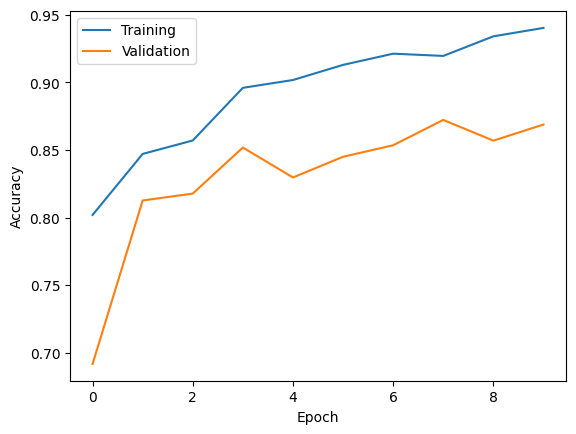

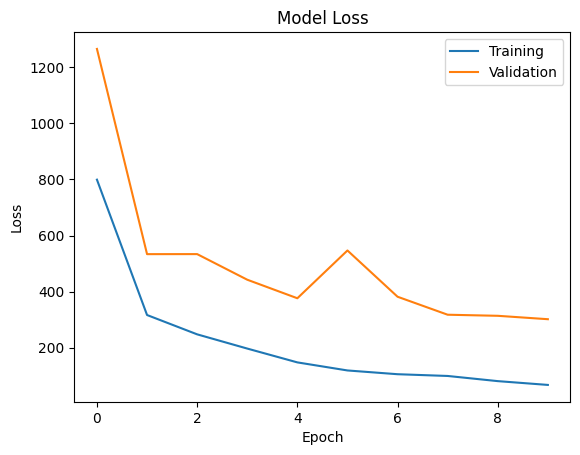

In [23]:
def plot_accuracy(history):
    plt.plot(history.history['dense_1_accuracy'])  # Adjust layer name based on the model
    plt.plot(history.history['val_dense_1_accuracy'])  # Adjust layer name based on the model
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['dense_1_loss'])  # Adjust layer name based on the model
    plt.plot(history.history['val_dense_1_loss'])  # Adjust layer name based on the model
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()

plot_accuracy(history1)
plot_loss(history1)


1/1 [==============================] - 1s 949ms/step
Dog prediction by ResNet
Intersection of Union = 0.701182343957489


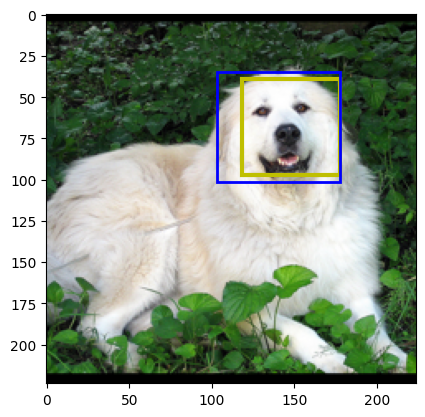

1/1 [==============================] - 0s 23ms/step
Dog prediction by ResNet
Intersection of Union = 0.6247176285077097


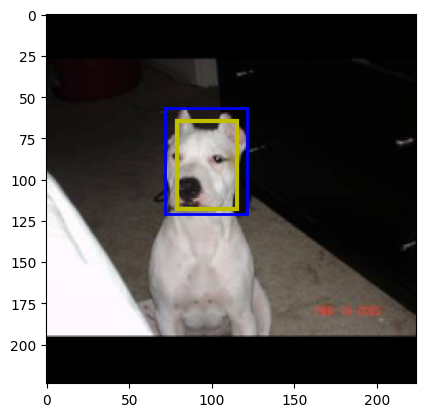

1/1 [==============================] - 0s 29ms/step
Dog prediction by ResNet
Intersection of Union = 0.36533928135331734


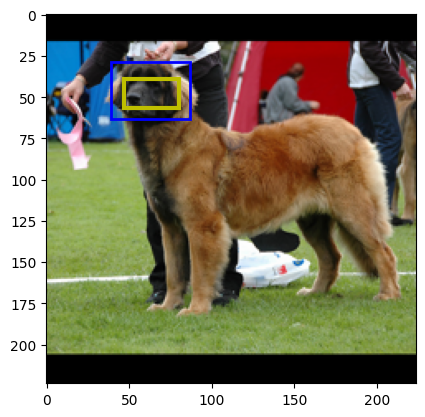

1/1 [==============================] - 0s 23ms/step
Dog prediction by ResNet
Intersection of Union = 0.5994879967297935


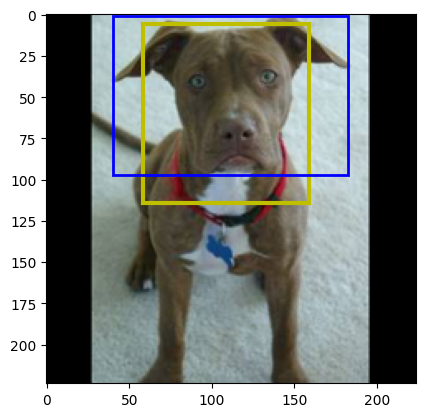

In [24]:
k = 0
while k < 4:
    i = np.random.randint(len(processed_data))
    img, species, true_bounding_box = processed_data[i]
    pred = model1.predict(np.array([preprocess_input(img)]))

    if pred[0][0] < 0.5:
        print("Cat prediction by ResNet")
    else:
        print("Dog prediction by ResNet")

    display_img_and_box(img, Bounding_Box(*pred[1][0]), true_bounding_box)
    k = k + 1

# EfficientNet<br>
Now applying transfer learning on another pre-trained architecture EfficientNet and see how this model performs for the task of image classification and localization.

In [14]:
from tensorflow.keras.applications import EfficientNetB0

# Load EfficientNetB0 with ImageNet weights
base_model2 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# Select the layers up to the 90th layer
selected_layers = base_model2.layers[:90]

# Create a new model with the selected layers
pruned_EfficientNet = Model(inputs=[base_model2.input], outputs=[selected_layers[-1].output])

# Classification output
classification_output2 = GlobalAveragePooling2D()(pruned_EfficientNet.output)
classification_output2 = Dense(units=1, activation='sigmoid')(classification_output2)

# Localization output
localization_output2 = Flatten()(pruned_EfficientNet.output)
localization_output2 = Dense(units=4, activation='relu')(localization_output2)

# Combine into the final model
model2 = Model(inputs=[pruned_EfficientNet.input], outputs=[classification_output2, localization_output2])

# Display model summary
model2.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0][0]'

In [15]:
model2.compile(optimizer='adam', metrics=['accuracy'],loss=['binary_crossentropy', 'mse'],loss_weights=[800, 1]  )

history2 = model2.fit(x_train, [y_train_class, y_train_box], validation_data=(x_validation, [y_validation_class, y_validation_box]),epochs=10,verbose=True)
history2

Epoch 1/10
75/75 [==============================] - 40s 231ms/step - loss: 1701.4464 - dense_2_loss: 0.6133 - dense_3_loss: 1210.8068 - dense_2_accuracy: 0.6907 - dense_3_accuracy: 0.7616 - val_loss: 8348.8389 - val_dense_2_loss: 7.8198 - val_dense_3_loss: 2093.0020 - val_dense_2_accuracy: 0.3031 - val_dense_3_accuracy: 0.4976
Epoch 2/10
75/75 [==============================] - 14s 190ms/step - loss: 644.8630 - dense_2_loss: 0.3955 - dense_3_loss: 328.4812 - dense_2_accuracy: 0.8326 - dense_3_accuracy: 0.8355 - val_loss: 1032.2622 - val_dense_2_loss: 0.4616 - val_dense_3_loss: 663.0189 - val_dense_2_accuracy: 0.7715 - val_dense_3_accuracy: 0.7877
Epoch 3/10
75/75 [==============================] - 15s 197ms/step - loss: 440.2639 - dense_2_loss: 0.3000 - dense_3_loss: 200.2955 - dense_2_accuracy: 0.8712 - dense_3_accuracy: 0.8678 - val_loss: 777.6815 - val_dense_2_loss: 0.3347 - val_dense_3_loss: 509.9298 - val_dense_2_accuracy: 0.8509 - val_dense_3_accuracy: 0.7893
Epoch 4/10
75/75 [==

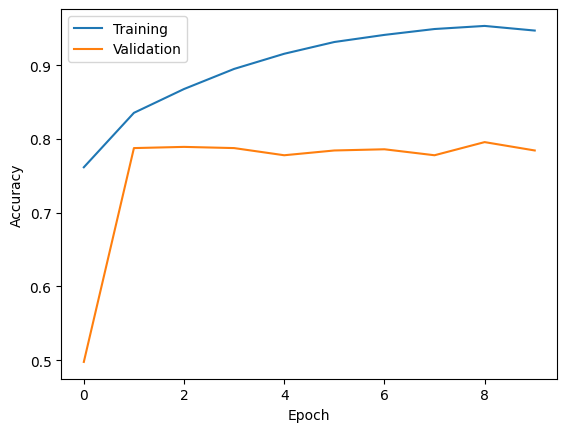

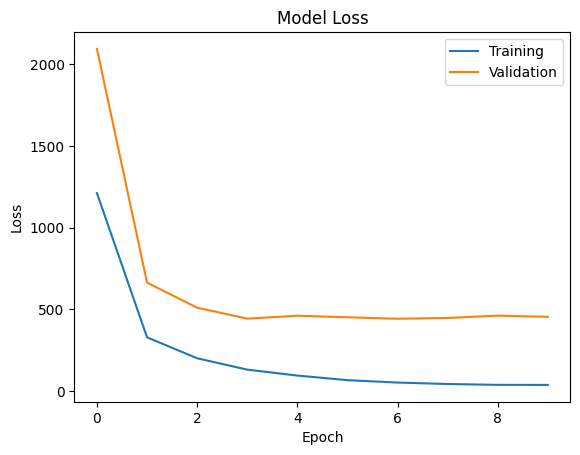

In [16]:
def plot_accuracy(history):
    plt.plot(history.history['dense_3_accuracy'])  # Adjust layer name based on the model
    plt.plot(history.history['val_dense_3_accuracy'])  # Adjust layer name based on the model
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['dense_3_loss'])  # Adjust layer name based on the model
    plt.plot(history.history['val_dense_3_loss'])  # Adjust layer name based on the model
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()


plot_accuracy(history2)
plot_loss(history2)

1/1 [==============================] - 1s 1s/step
Cat prediction by EfficientNetBO
Intersection of Union = 0.8253574191467953


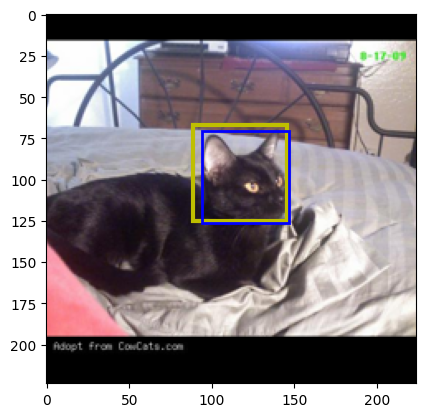

1/1 [==============================] - 0s 27ms/step
Dog prediction by EfficientNetBO
Intersection of Union = 0.7170514392978327


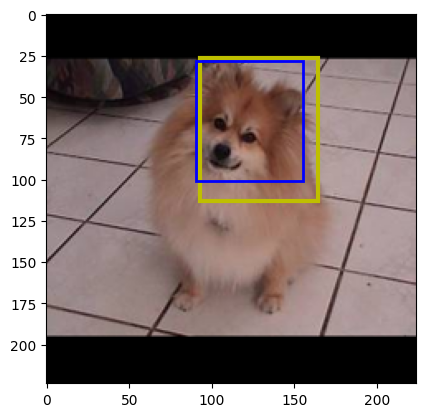

1/1 [==============================] - 0s 23ms/step
Dog prediction by EfficientNetBO
Intersection of Union = 0.6343685319583408


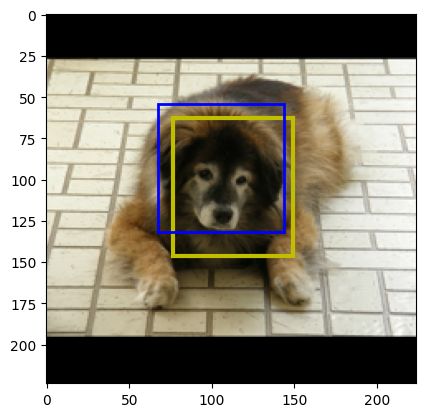

1/1 [==============================] - 0s 24ms/step
Cat prediction by EfficientNetBO
Intersection of Union = 0.5749444771240033


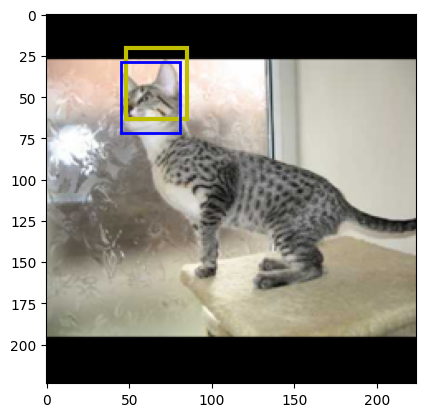

In [17]:
k = 0
while k < 4:
    i = np.random.randint(len(processed_data))
    img, species, true_bounding_box = processed_data[i]
    pred = model2.predict(np.array([preprocess_input(img)]))

    if pred[0][0] < 0.5:
        print("Cat prediction by EfficientNetBO")
    else:
        print("Dog prediction by EfficientNetBO")

    display_img_and_box(img, Bounding_Box(*pred[1][0]), true_bounding_box)
    k = k + 1